## Air Passengers Time Series Forecasting 

In this notebook, I will demostrate time series forecasting in python using the popular Air Passengers dataset.

Time Series (TS) data consists of a collection data points collected at fixed intervals of time. This time dependant data can be analysed to  find out the patterns like trend and seasonality which in turn can be used to forecast future events. There are mainly two things that make a TS data different from a standard tabular data, these are:

 - TS data is time dependant, this means the assumption of a linear regression model which states that the observations are independant is not valid here. 
 - TS data has trends and seasonality which makes the analysis of such data particularly tricky. 

### Basic Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

### The Data 

In [2]:
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null object
#Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


### Converting Index into Date-time object

We can see that Month is a coloumn in this dataset. For our purpose, we need this column to be our index and this index must be a Date-time object. 

In [4]:
data.set_index("Month",inplace=True)

In [5]:
data.head()

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [6]:
data.index = pd.to_datetime(data.index)

In [7]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
#Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


### Plotting TS data 

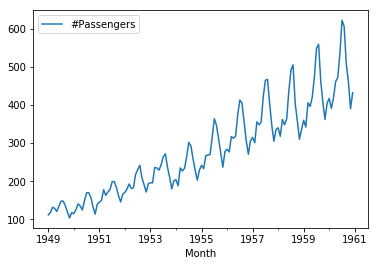

In [9]:
data.plot()

We can already see an upward trend and seasonality in the data.

In [10]:
data.loc['1949-01-01':'1949-06-01'] # indexing all the values for the year 1949 

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135


### Checking for missing values

In [11]:
import seaborn as sns

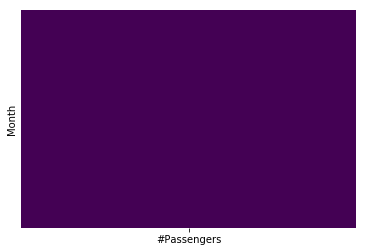

In [12]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Checking Stationarity 

We need to do this because most of the TS models work on the assumtion that the TS data is stationary, i.e it's statistical properties such as mean and variance remain constant over time. This countering the basic idea of TS modelling but nevertheless, that's how it is. Models such as ARIMA expects the data to be stationary but we cannot loose the TS information either since that's the whole point here. This means that, we some how must incorporate the TS information in the stationary data before feeding it to the TS models. I will be going through some of such commonly used methods in this notebook. 

We can say that a series is stationary if it obeys the following criterion. 

- Constant Mean
- Constant Variance
- An autocovariance that is independent of time. 


We can check the check stationarity using the following:

- Plotting Rolling Statistics: It is nothing but plotting a moving average 
- Dickey-Fuller Test: This is one of the statistical tests for checking stationarity where the null hypothesis is the TS is non-stationary

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
def stationarity_test(TS):
    
    # Determing rolling statistics using a window size = 12 
    
    roll_mean = TS.rolling(window=12).mean()
    roll_std = TS.rolling(window=12).std()
    
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS,color = 'blue',label='Real_data')
    plt.plot(roll_mean,color = 'red',label='Moving Average')
    plt.plot(roll_std,color='black',label='Moving Std')
    plt.legend()
    plt.title('Moving Average and Standard Deviation')
    
    #Perform Dickey-Fuller test:
    print('--------------------')
    
    print('Dickey-Fuller test Results:')
    print('\n')
    
    df_test = adfuller(TS.iloc[:,0],autolag='AIC')
    
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for k,v in df_test[4].items():
        
        df_output['Critical Value (%s)'%k] = v 
        
    print(df_output)
    

--------------------
Dickey-Fuller test Results:


Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


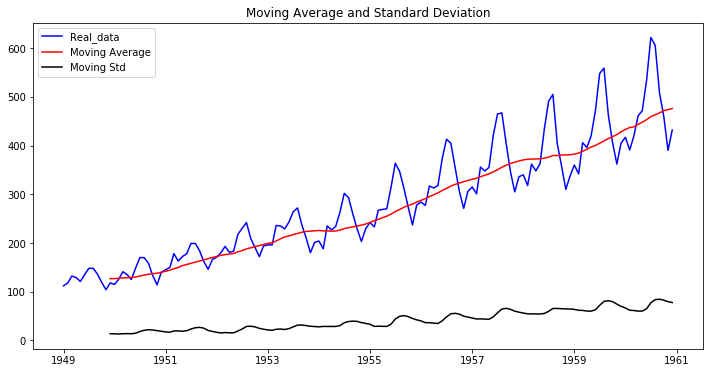

In [15]:
stationarity_test(data)

We can definitely say that this data is not stationary since the moving average clearly shows an upward trend and also the test statistic is much higher than the critical values. 

### Making the TS data Stationary 

As explained before we need to make the data stationary so that TS models can process it but in reality almost all TS data is not stationary. Although it is nearly impossible to make a TS perfectly stationary, we can try the following steps to make it as stationary as possible. 

There are mainly two things that make a TS non stationary, they are: 

- Trend 
- Seasonality 

Therefore, in-order to make a TS stationary we must first estimate and eliminate trend and seasonality from the TS data. 

### Estimating & Eliminating Trend



#### Log transformation 

In [16]:
data_log = np.log(data)

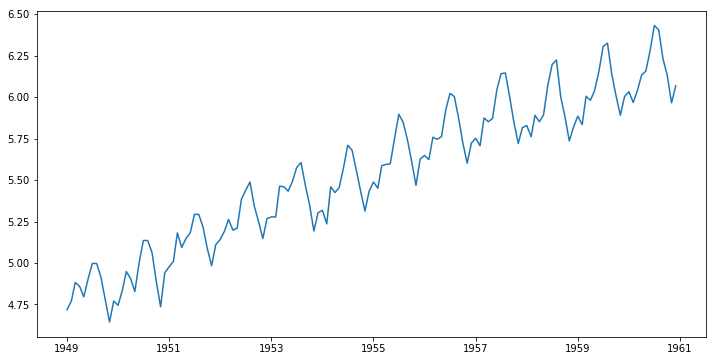

In [17]:
fig = plt.figure(figsize=(12,6))
plt.plot(data_log)

We can clearly see an upward trend in the data. We can use the following methods to estimate and remove this trend from the data. 

- Aggregation : taking average for a time period like monthly/weekly averages
- Smoothing : taking rolling/moving averages
- Polynomial Fitting : fitting a regression model

I will be using smoothing here, it is nothing but taking rolling estimates

#### Moving average 

In [18]:
moving_avg = data_log.rolling(window=12).mean()

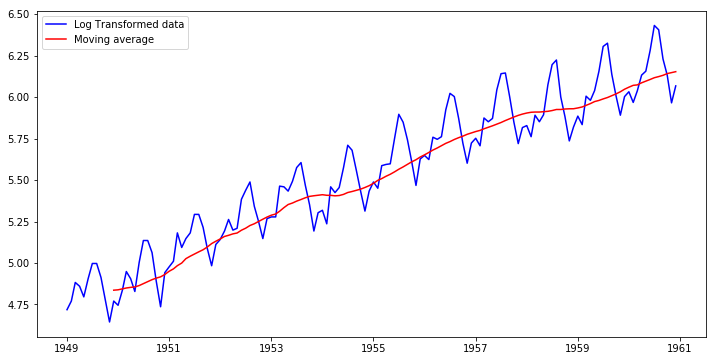

In [19]:
fig = plt.figure(figsize=(12,6))
plt.plot(data_log,color='blue',label='Log Transformed data')
plt.plot(moving_avg,color='red',label='Moving average')
plt.legend()

We can substract the moving average from the log transformed data. Notice that the first 11 values in the new data is NaN, this is because we difined our window to be 12 and hence the average is taken for 12 values at a time.   

In [20]:
data_log_moving_avg_diff = data_log - moving_avg
data_log_moving_avg_diff.head(14)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [21]:
data_log_moving_avg_diff.dropna(inplace=True)

In [22]:
data_log_moving_avg_diff.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


--------------------
Dickey-Fuller test Results:


Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


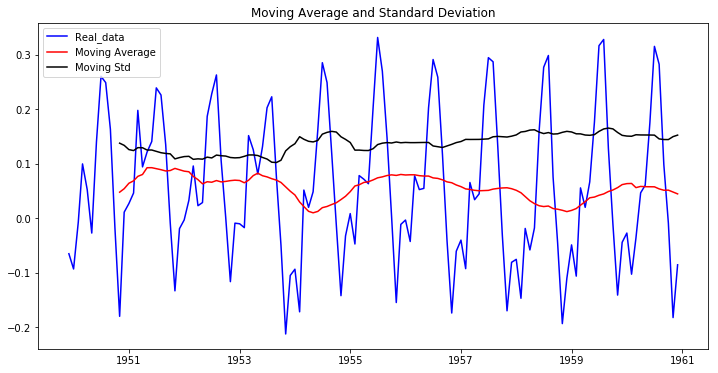

In [23]:
stationarity_test(data_log_moving_avg_diff)

From the figure itself it is clear that we have successfuly removed the upward trend in the data, therefore we have eliminated the tred from the data. We can further confirm this by looking at the Test Statistic and Critical Value (5%), here the former is less than the latter and therfore we can say with 95% confidence that we have removed the trend from the data. 

#### Exponentially weighted moving average 

There is a drawback in traditional moving average calculations, here we must specify the window size beforehand. This was ok in this case because we knew we were dealing with yearly data so that we could set the window size to 12. This is not possible in more complex systems where we do not have an idea as to how to set this window size. This is where exponentially weighted moving average comes in. In this method recent values are given more importance than old values by assigning wights to each value using a decay factor.

In [24]:
exp_weighted_moving_avg = data_log.ewm(halflife=12).mean()

# halflife is used to define the exponential decay
# this is just a hayper-parameter, choise will largely depend on the domain of application
# Other parameters like span and center of mass can also be used to define decay

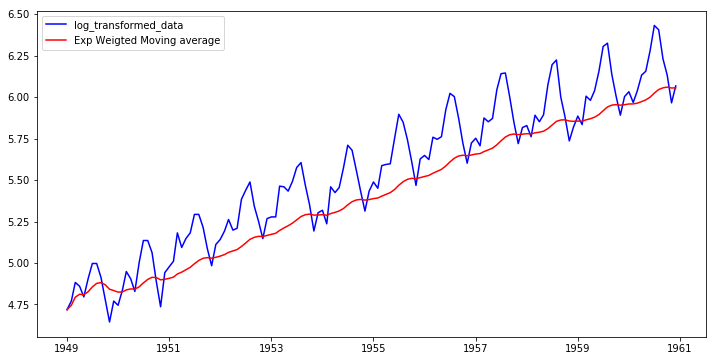

In [25]:
fig = plt.figure(figsize=(12,6))
plt.plot(data_log,color='blue',label='log_transformed_data')
plt.plot(exp_weighted_moving_avg,color='red',label='Exp Weigted Moving average')
plt.legend()

In [26]:
data_log_exp_avg_diff = data_log - exp_weighted_moving_avg

In [27]:
data_log_exp_avg_diff.head()

,#Passengers
Month,
1949-01-01,0.000000
1949-02-01,0.025339
1949-03-01,0.088967
1949-04-01,0.048028
1949-05-01,-0.012415


We can see that here unlike the normal moving average, the first values are not NaN. This is the biggest advantage of EWMA or any other weighted average calcaulations in general. Therfore,we don't lose any available information and will get a bettet and smoother curve. 

--------------------
Dickey-Fuller test Results:


Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


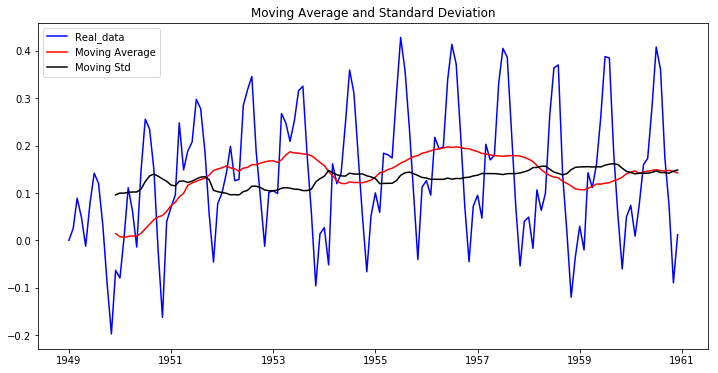

In [28]:
stationarity_test(data_log_exp_avg_diff)

The results are visibly better than normal moving average. The Test Statistic is less than 1% Critical Value and the magnitude of variations in the mean and std is much lesser. 

### Estimating & Eliminating Trend and Seasonality 

In TS data with both tred and seasonality we must remove both of them from the data before developing a model. The techniqes shown above can only remove trend from the data. In order to remove both seasonality and trend, we must either difference or decompose the data in such a way that the process removes both trend and seasonality from the data and gives us back a residual. Once we have this residual, we can build our model using this residual as the input data to the TS forecasting model.  

#### Differencing

In [29]:
data_log_diff = data_log - data_log.shift(periods=1)

In [30]:
data_log_diff.head() # one NaN corresponding to one shift 

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022


In [31]:
data_log_diff.dropna(inplace=True)

--------------------
Dickey-Fuller test Results:


Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


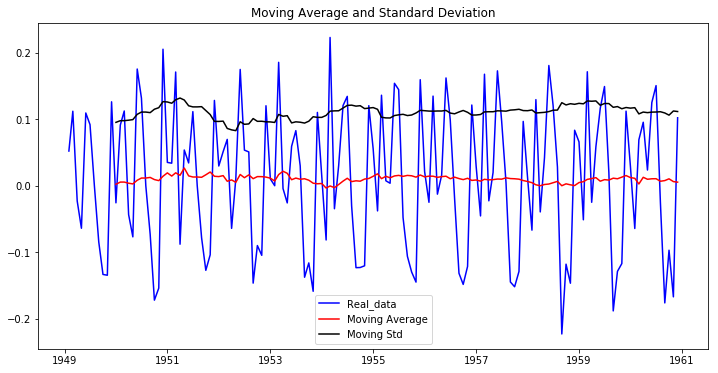

In [32]:
stationarity_test(data_log_diff)

This is just a 1st order differencing, we may use 2nd, 3rd order differencing and so on depending on the complexity of the task. 

#### Decomposing

Here, both trend and seasonality are modelled seperately. The process returns a residual after removing both trend and seasonality.

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [34]:
decomp = seasonal_decompose(data_log)

In [35]:
trend = decomp.trend
seasonality = decomp.seasonal
residual = decomp.resid

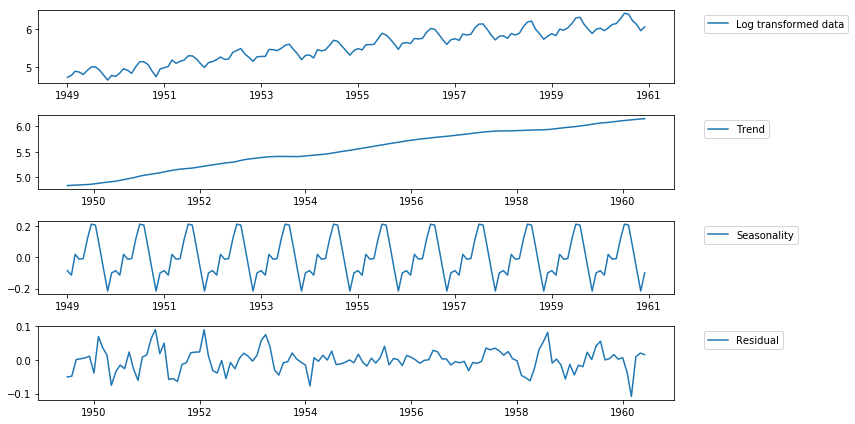

In [36]:
fig = plt.figure(figsize=(12,6))

plt.subplot(411)
plt.plot(data_log,label='Log transformed data')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.subplot(413)
plt.plot(seasonality,label='Seasonality')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()

We can see that the trend and seasonality is seperated from the data and a clean resuidual is returned. We can now check the stationarity of this residual. 

In [37]:
data_log_decom = residual

In [38]:
data_log_decom.head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


In [39]:
data_log_decom.dropna(inplace=True)

--------------------
Dickey-Fuller test Results:


Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


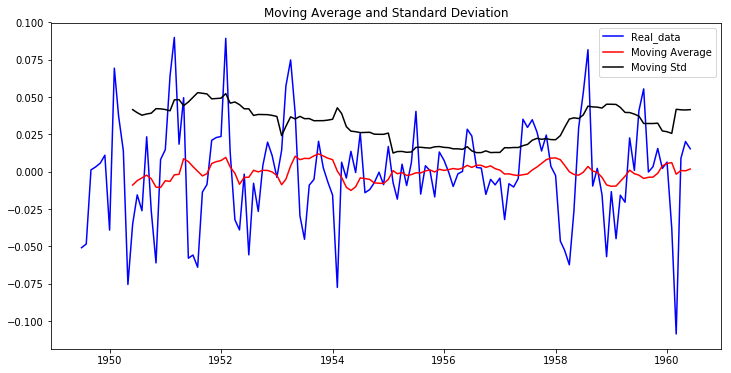

In [40]:
stationarity_test(data_log_decom)

This is a near perfect stationary series since the Test Statistic is much less than the 1% Critical Value

### Forecasting 

After performing the trend and seasonality estimation, we will arrive at the following two possibilities:

 - A purely stationary series - This has no dependencies amoung its values and hence can be modelled just using the residuals, but this is very rare.
 - A series that still has significant dependencies amoung its values. This is where we must use some statistical models like ARIMA to forecast the data.
 
ARIMA stands for Auto-Regressive Integrated Moving Averages. Mathematically ARIMA is like a linear regression model where the predictiors depend on the parameters (p,d,q) of the ARIMA model

 - AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable
 - MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation
 - Differences (d): These are the number of nonseasonal differences, these can be of any order. 
 
The key here is determinig the values of p and q. There are two statistical tools for this task: 

 - Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. It gives information about the number of MA (q) terms. 
 - Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. It gives gives information about the number of AR (p) terms. 
 
I will demonstrate 3 different ARIMA models:

 - AR Model (just using the AR terms)
 - MA Model (just using the MA terms)
 - ARIMA Model (combining both AR and MA terms)
 
I will be using the previous first order differenced model here. 

### ACF and PACF plots 

In [41]:
from statsmodels.tsa.stattools import acf,pacf

In [42]:
acf_lag = acf(data_log_diff,nlags=20)
pacf_lag = pacf(data_log_diff,nlags=20,method='ols')

Text(0.5,1,'Partial Autocorrelation Plot')

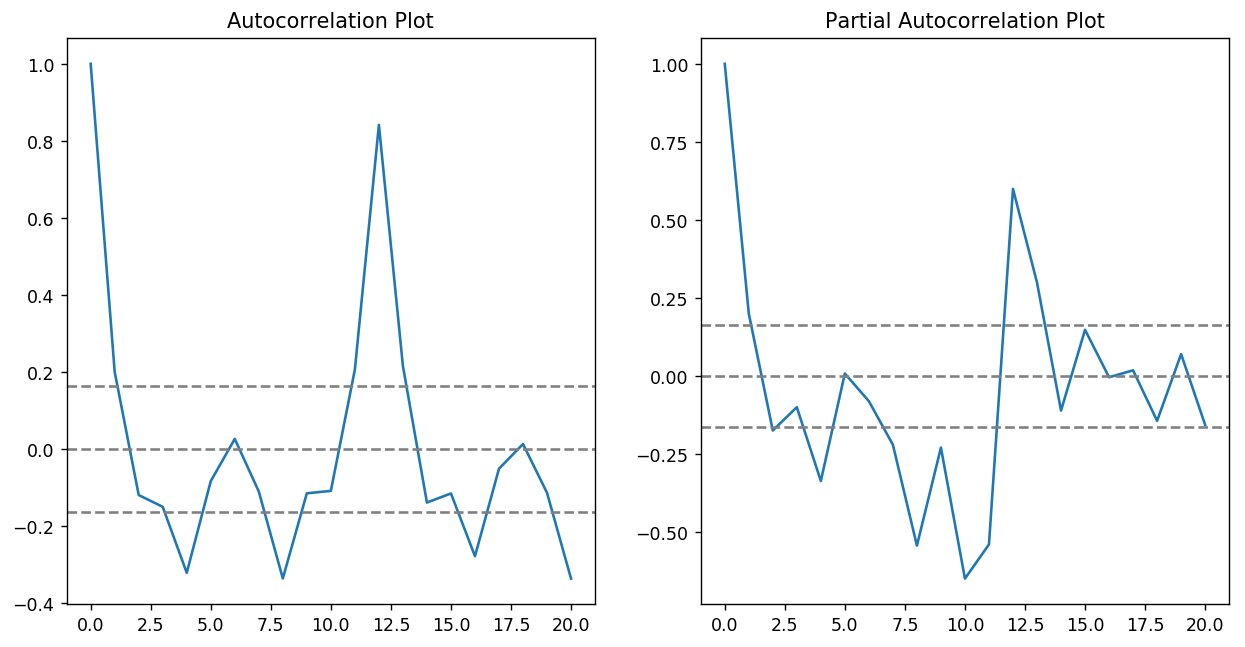

In [43]:
fig = plt.figure(figsize=(12,6),dpi=125)
plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Plot')

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Plot')

From the above two plots we can conclude that our model will have:

 - MA (q) = 2, given by the Autocorrelation plot
 - AR (p) = 2, given by the Partial Autocorrelation plot 

In [44]:
from statsmodels.tsa.arima_model import ARIMA

#### AR Model

In [45]:
# order indicates (p,d,q)
# 2 AR number, p
# 1 Order of differencing, d
# 0 MA number, q
# This is a pure AR model 

ar_model = ARIMA(data_log,order=(2,1,0),freq=data_log.index.inferred_freq)

In [46]:
ar_result = ar_model.fit(disp=-1)

Text(0.5,1,'AR Model')

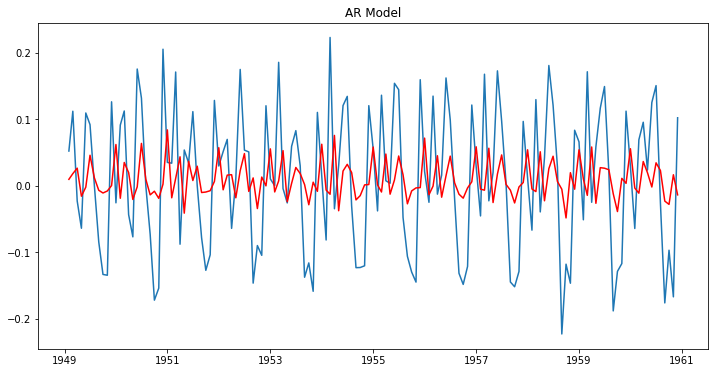

In [47]:
fig = plt.figure(figsize=(12,6))
plt.plot(data_log_diff)
plt.plot(ar_result.fittedvalues,color='red')
plt.title('AR Model')

#### MA Model

In [48]:
ma_model = ARIMA(data_log,order=(0,1,2),freq=data_log.index.inferred_freq)

In [49]:
ma_resutl = ma_model.fit(disp=-1)

Text(0.5,1,'MA Model')

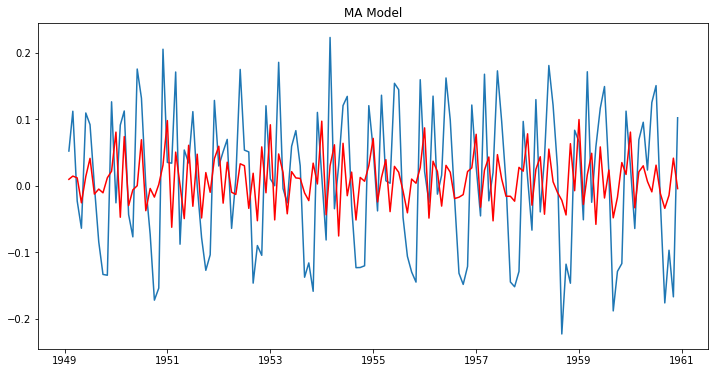

In [50]:
fig = plt.figure(figsize=(12,6))
plt.plot(data_log_diff)
plt.plot(ma_resutl.fittedvalues,color='red')
plt.title('MA Model')

#### ARIMA Model

In [51]:
arima_model = ARIMA(data_log,order=(2,1,2),freq=data_log.index.inferred_freq)

In [52]:
arima_result = arima_model.fit(disp=-1)

Text(0.5,1,'ARIMA Model')

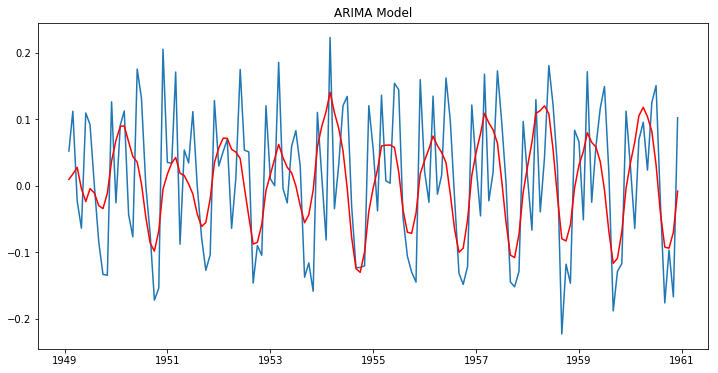

In [53]:
fig = plt.figure(figsize=(12,6))
plt.plot(data_log_diff)
plt.plot(arima_result.fittedvalues,color='red')
plt.title('ARIMA Model')

From above plots we can clearly infer that, we cannot model our data either as a pure AR or pure MA model, out data is a perfect candidate for an ARIMA model. Only an ARIMA model can capture the seasonal fluctuations of our data effectively. 